# STEP and STL Import for torch-fem

This notebook demonstrates how to import STEP and STL geometry files into torch-fem using gmsh for meshing.

Since torch-fem doesn't include a built-in mesher, we use:
- **gmsh**: For meshing STEP and STL files into tetrahedral or hexahedral elements
- **meshio**: For reading/writing various mesh formats
- Custom converter functions to create torch-compatible tensors

The approach is to create helper functions that:
1. Load geometry from STEP/STL files
2. Generate FEM mesh using gmsh
3. Convert to torch tensors (nodes, elements)
4. Use with existing torch-fem classes (no subclassing needed!)


## 1. Install Required Dependencies

First, ensure you have the necessary packages installed:
- `gmsh`: For geometry import and meshing
- `meshio`: For mesh file I/O
- `torch-fem`: For FEM analysis

In [18]:
# Install required packages (uncomment if needed)
# !pip install gmsh meshio torch-fem

# Verify installations
import subprocess
import sys

packages = ['gmsh', 'meshio', 'torch', 'torchfem']
for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} is installed")
    except ImportError:
        print(f"✗ {package} is NOT installed - run: pip install {package}")

✓ gmsh is installed
✓ meshio is installed
✓ torch is installed
✓ torchfem is installed


## 2. Import Libraries

In [19]:
import torch
import numpy as np
from pathlib import Path
import sys

# Add .vscode directory to path to import our converter
sys.path.insert(0, str(Path.cwd() / '.vscode'))

# Import our custom mesh converter
from step_to_torch_fem_mesh import import_geometry, export_to_vtk, find_nodes_in_box

# torch-fem imports
from torchfem import Solid
from torchfem.materials import IsotropicElasticity3D

# Set default torch dtype
torch.set_default_dtype(torch.float64)

print("All libraries imported successfully!")

All libraries imported successfully!


## 3. Import STEP File and Generate Mesh

We'll use the `import_geometry` function which:
1. Loads STEP/STL geometry using gmsh
2. Generates a tetrahedral or hexahedral mesh
3. Returns torch tensors (nodes, elements) ready for torch-fem

In [20]:
# Import STEP file and generate mesh
nodes, elements = import_geometry(
    'bridge_v2.step',  # Your STEP file path
    mesh_size=2.0,       # Target mesh element size
    element_type='tet4', # 4-node tetrahedron (linear elements)
    dim=3,               # 3D mesh
    verbose=True
)

print(f"\n✓ Mesh imported successfully!")
print(f"  Nodes: {nodes.shape}")
print(f"  Elements: {elements.shape}")
print(f"  Data type: {nodes.dtype}")

Info    :  - Label 'Shapes/(Unsaved)' (3D)
Info    :  - Color (0.627451, 0.627451, 0.627451) (3D & Surfaces)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 50%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Line)
Info    : [ 60%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 80%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 90%] Meshing curve 21 (Line)
Info    : [ 90%

## 4. Inspect the Mesh

Let's examine the mesh structure and verify it matches torch-fem requirements.

In [21]:
# Inspect mesh structure
print("Mesh Structure:")
print("=" * 60)
print(f"Number of nodes: {len(nodes)}")
print(f"Number of elements: {len(elements)}")
print(f"Nodes per element: {elements.shape[1]}")
print(f"\nBounding box:")
print(f"  X: [{nodes[:, 0].min():.3f}, {nodes[:, 0].max():.3f}]")
print(f"  Y: [{nodes[:, 1].min():.3f}, {nodes[:, 1].max():.3f}]")
print(f"  Z: [{nodes[:, 2].min():.3f}, {nodes[:, 2].max():.3f}]")

print(f"\nFirst 3 nodes:")
print(nodes[:3])

print(f"\nFirst 3 elements (node connectivity):")
print(elements[:3])

Mesh Structure:
Number of nodes: 1559
Number of elements: 5127
Nodes per element: 4

Bounding box:
  X: [-30.000, 0.000]
  Y: [0.000, 105.000]
  Z: [0.000, 20.000]

First 3 nodes:
tensor([[ 1.1102e-15,  5.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-3.0000e+01,  6.6613e-15,  0.0000e+00]])

First 3 elements (node connectivity):
tensor([[ 552,  502,  578, 1547],
        [1337, 1365, 1399, 1444],
        [1337, 1399, 1370, 1444]])


## 5. Create torch-fem Solid Model

Now we can directly use the imported mesh with torch-fem's `Solid` class - **no subclassing needed!**

In [22]:
# Define material (Steel)
material = IsotropicElasticity3D(
    E=210000.0,  # Young's modulus in MPa
    nu=0.3       # Poisson's ratio
)

# Create Solid FEM model directly with imported mesh
model = Solid(nodes, elements, material)

print(f"✓ FEM model created successfully!")
print(f"  Degrees of freedom: {model.n_dofs}")
print(f"  Nodes: {model.n_nod}")
print(f"  Elements: {model.n_elem}")
print(f"  Dimensions: {model.n_dim}D")

✓ FEM model created successfully!
  Degrees of freedom: 4677
  Nodes: 1559
  Elements: 5127
  Dimensions: 3D


## 6. Apply Boundary Conditions

We'll use the helper function `find_nodes_in_box` to select nodes by geometric location.

In [26]:
# Get bounding box
xmin, xmax = nodes[:, 0].min().item(), nodes[:, 0].max().item()
ymin, ymax = nodes[:, 1].min().item(), nodes[:, 1].max().item()
zmin, zmax = nodes[:, 2].min().item(), nodes[:, 2].max().item()

print(f"Mesh bounding box:")
print(f"  X: [{xmin:.3f}, {xmax:.3f}] - length = {xmax-xmin:.3f}")
print(f"  Y: [{ymin:.3f}, {ymax:.3f}] - length = {ymax-ymin:.3f} ← LONG (bridge span)")
print(f"  Z: [{zmin:.3f}, {zmax:.3f}] - length = {zmax-zmin:.3f}")

# Bridge configuration: Y is the long direction (span)
# Fix ONLY the TWO SHORT ENDS (perpendicular to Y-axis)
# These are at y=ymin and y=ymax

# Select SHORT END #1 (at y=ymin) - perpendicular to the bridge span
end_1 = find_nodes_in_box(nodes, ymin=ymin, ymax=ymin, zmin=zmin, zmax=zmax, tolerance=0.1)

# Select SHORT END #2 (at y=ymax) - perpendicular to the bridge span  
end_2 = find_nodes_in_box(nodes, ymin=ymax, ymax=ymax, zmin=zmin, zmax=zmax, tolerance=0.1)

# Combine both short ends
fixed_nodes = torch.cat([end_1, end_2])
fixed_nodes = torch.unique(fixed_nodes)  # Remove any duplicates

print(f"\n✓ Fixed {len(end_1)} nodes at SHORT END #1 (y={ymin:.2f})")
print(f"✓ Fixed {len(end_2)} nodes at SHORT END #2 (y={ymax:.2f})")
print(f"✓ Total constrained nodes: {len(fixed_nodes)}")
print(f"  These are the ends PERPENDICULAR to the Y-span")

model.constraints[fixed_nodes, :] = True  # Fix all DOFs (x, y, z) at both short ends

# Apply distributed load on TOP surface (z = zmax)
load_nodes = find_nodes_in_box(nodes, zmin=zmax, zmax=zmax, tolerance=0.1)
print(f"\n✓ Applying distributed load to {len(load_nodes)} nodes on top surface (z={zmax:.2f})")

# Distribute total force over all top nodes (downward in Z direction)
total_force = -1000.0  # N (downward in -Z direction)
force_per_node = total_force / len(load_nodes)
model.forces[load_nodes, 2] = force_per_node  # Z-direction (downward)

print(f"✓ Total force: {total_force:.1f} N distributed over top surface")
print(f"✓ Force per node: {force_per_node:.3f} N in -Z direction")
print(f"\nBoundary conditions applied successfully!")
print("📐 Bridge setup: SHORT ENDS constrained (y=min & y=max), free along long sides")

Mesh bounding box:
  X: [-30.000, 0.000] - length = 30.000
  Y: [0.000, 105.000] - length = 105.000 ← LONG (bridge span)
  Z: [0.000, 20.000] - length = 20.000

✓ Fixed 99 nodes at SHORT END #1 (y=0.00)
✓ Fixed 100 nodes at SHORT END #2 (y=105.00)
✓ Total constrained nodes: 199
  These are the ends PERPENDICULAR to the Y-span

✓ Applying distributed load to 430 nodes on top surface (z=20.00)
✓ Total force: -1000.0 N distributed over top surface
✓ Force per node: -2.326 N in -Z direction

Boundary conditions applied successfully!
📐 Bridge setup: SHORT ENDS constrained (y=min & y=max), free along long sides


## 6.5 Visualize Boundary Conditions

Before solving, let's visualize the constraints and loads to verify the setup.

In [27]:
import pyvista as pv
import numpy as np

# Create PyVista mesh for visualization
points = nodes.cpu().numpy()
cells = elements.cpu().numpy()

# Create VTK cells (prepend count of nodes per element)
vtk_cells = np.column_stack([np.full(len(cells), 4), cells]).ravel()
celltypes = np.full(len(cells), pv.CellType.TETRA)

pv_mesh = pv.UnstructuredGrid(vtk_cells, celltypes, points)

print("✓ Created PyVista mesh for BC visualization")

✓ Created PyVista mesh for BC visualization


✓ Visualizing 199 constrained nodes (RED)
✓ Visualizing 430 loaded nodes (GREEN) with force arrows


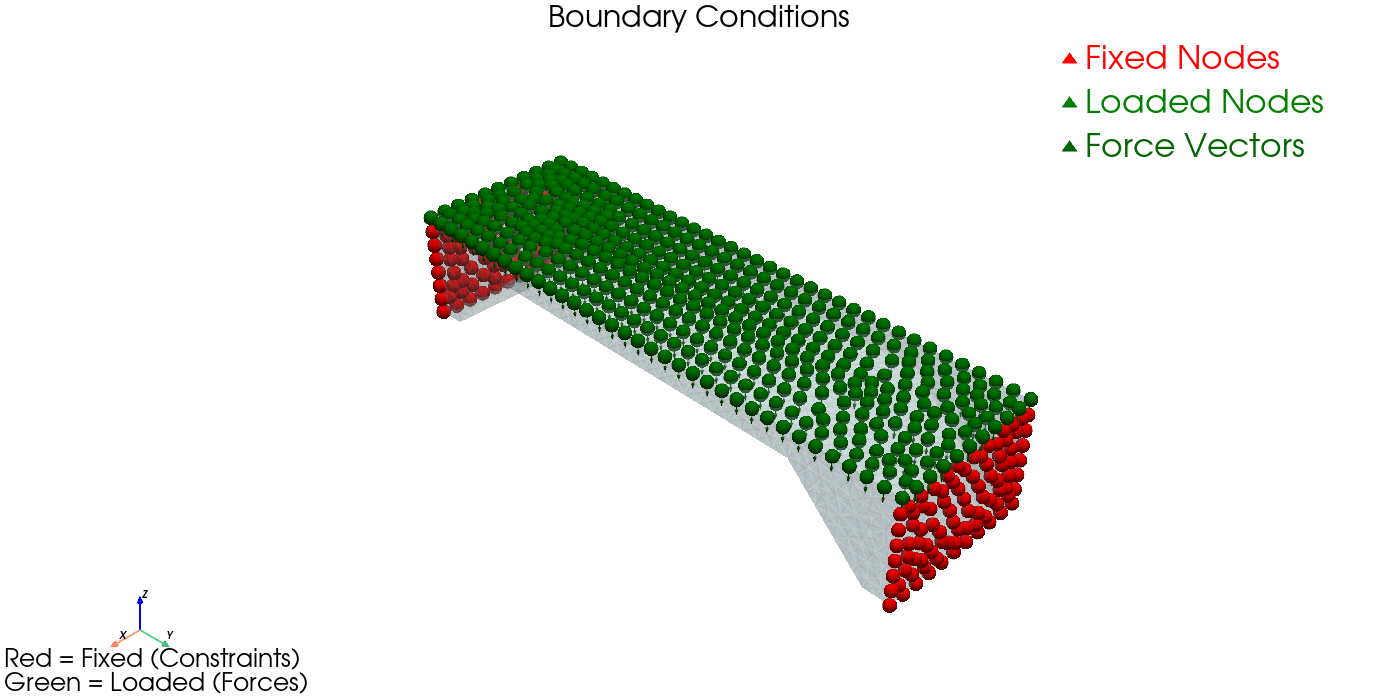

In [28]:
# Visualize boundary conditions
plotter = pv.Plotter(window_size=[1400, 700])

# Add the main mesh (semi-transparent)
plotter.add_mesh(pv_mesh, color='lightblue', opacity=0.3, show_edges=True, 
                edge_color='gray', line_width=0.5)

# Visualize FIXED NODES (constraints)
# Find nodes with any constraint
constrained_mask = model.constraints.any(dim=1).cpu().numpy()
constrained_nodes = nodes[constrained_mask].cpu().numpy()

if len(constrained_nodes) > 0:
    # Add fixed nodes as red spheres
    fixed_points = pv.PolyData(constrained_nodes)
    plotter.add_mesh(fixed_points, color='red', point_size=15, 
                    render_points_as_spheres=True, label='Fixed Nodes')
    print(f"✓ Visualizing {len(constrained_nodes)} constrained nodes (RED)")

# Visualize LOADED NODES (forces)
# Find nodes with non-zero forces
force_mask = (model.forces.abs() > 1e-10).any(dim=1).cpu().numpy()
loaded_nodes = nodes[force_mask].cpu().numpy()
force_vectors = model.forces[force_mask].cpu().numpy()

if len(loaded_nodes) > 0:
    # Add loaded nodes as green spheres
    load_points = pv.PolyData(loaded_nodes)
    plotter.add_mesh(load_points, color='green', point_size=15, 
                    render_points_as_spheres=True, label='Loaded Nodes')
    
    # Add force arrows
    # Scale arrows for visibility
    arrow_scale = (nodes[:, 0].max() - nodes[:, 0].min()).item() * 0.1
    force_magnitude = np.linalg.norm(force_vectors, axis=1, keepdims=True)
    force_directions = force_vectors / (force_magnitude + 1e-10)
    scaled_vectors = force_directions * arrow_scale
    
    plotter.add_arrows(loaded_nodes, scaled_vectors, mag=1.0, 
                      color='darkgreen', label='Force Vectors')
    print(f"✓ Visualizing {len(loaded_nodes)} loaded nodes (GREEN) with force arrows")

# Add legend and labels
plotter.add_legend()
plotter.add_text("Boundary Conditions", position='upper_edge', font_size=12)
plotter.add_text(f"Red = Fixed (Constraints)\nGreen = Loaded (Forces)", 
                position='lower_left', font_size=10)
plotter.add_axes()
plotter.camera_position = 'iso'

# Show
plotter.show(jupyter_backend='static')

In [29]:
# Detailed BC information
print("\n" + "="*60)
print("BOUNDARY CONDITIONS SUMMARY")
print("="*60)

# Constraints info
n_constrained_nodes = constrained_mask.sum()
n_constrained_dofs = model.constraints.sum().item()
print(f"\nCONSTRAINTS (Fixed):")
print(f"  Nodes with constraints: {n_constrained_nodes}")
print(f"  Total DOFs constrained: {int(n_constrained_dofs)}")

# Check which DOFs are constrained
dof_names = ['X', 'Y', 'Z']
for i, dof in enumerate(dof_names):
    n_dof = model.constraints[:, i].sum().item()
    if n_dof > 0:
        print(f"  {dof}-direction constrained: {int(n_dof)} nodes")

# Forces info
n_loaded_nodes = force_mask.sum()
total_force_vector = model.forces.sum(dim=0).cpu().numpy()
print(f"\nFORCES (Loads):")
print(f"  Nodes with forces: {n_loaded_nodes}")
print(f"  Total force vector:")
for i, dof in enumerate(dof_names):
    print(f"    F_{dof} = {total_force_vector[i]:.3f} N")
total_force_magnitude = np.linalg.norm(total_force_vector)
print(f"  Total force magnitude: {total_force_magnitude:.3f} N")

# Max individual forces
max_forces = model.forces.abs().max(dim=0)[0].cpu().numpy()
print(f"\n  Max nodal forces:")
for i, dof in enumerate(dof_names):
    print(f"    Max |F_{dof}| = {max_forces[i]:.3f} N")

print("="*60)


BOUNDARY CONDITIONS SUMMARY

CONSTRAINTS (Fixed):
  Nodes with constraints: 199
  Total DOFs constrained: 597
  X-direction constrained: 199 nodes
  Y-direction constrained: 199 nodes
  Z-direction constrained: 199 nodes

FORCES (Loads):
  Nodes with forces: 430
  Total force vector:
    F_X = 0.000 N
    F_Y = 0.000 N
    F_Z = -1000.000 N
  Total force magnitude: 1000.000 N

  Max nodal forces:
    Max |F_X| = 0.000 N
    Max |F_Y| = 0.000 N
    Max |F_Z| = 2.326 N


## 7. Solve the FEM Problem

In [30]:
# Solve the FEM problem
u, f, sigma, F, alpha = model.solve()

print("✓ Solution computed successfully!")
print(f"  Displacement shape: {u.shape}")  # (n_nodes, 3)
print(f"  Stress shape: {sigma.shape}")    # (n_elements, 3, 3)

✓ Solution computed successfully!
  Displacement shape: torch.Size([1559, 3])
  Stress shape: torch.Size([5127, 3, 3])


## 8. Calculate Von Mises Stress

In [31]:
# Extract stress components
sigma_xx = sigma[:, 0, 0]
sigma_yy = sigma[:, 1, 1]
sigma_zz = sigma[:, 2, 2]
sigma_xy = sigma[:, 0, 1]
sigma_xz = sigma[:, 0, 2]
sigma_yz = sigma[:, 1, 2]

# Calculate Von Mises stress
# σ_vm = sqrt(0.5*((σxx-σyy)² + (σyy-σzz)² + (σzz-σxx)²) + 3*(τxy² + τxz² + τyz²))
von_mises = torch.sqrt(
    0.5 * ((sigma_xx - sigma_yy)**2 + 
           (sigma_yy - sigma_zz)**2 + 
           (sigma_zz - sigma_xx)**2) +
    3.0 * (sigma_xy**2 + sigma_xz**2 + sigma_yz**2)
)

# Calculate displacement magnitude
u_mag = torch.norm(u, dim=1)

print("Results Summary:")
print("=" * 60)
print(f"Max displacement: {u_mag.max().item():.6e} mm")
print(f"Max Von Mises stress: {von_mises.max().item():.3f} MPa")
print(f"Min Von Mises stress: {von_mises.min().item():.3f} MPa")
print(f"Mean Von Mises stress: {von_mises.mean().item():.3f} MPa")
print("=" * 60)

Results Summary:
Max displacement: 5.292911e-03 mm
Max Von Mises stress: 12.330 MPa
Min Von Mises stress: 0.317 MPa
Mean Von Mises stress: 3.318 MPa


## 9. Export Results to VTK for Visualization

Export the results to VTK format to visualize in ParaView.

In [32]:
# Export to VTK
export_to_vtk(
    'imported_step_results.vtk',
    nodes=nodes,
    elements=elements,
    element_type='tet4',
    point_data={
        'displacement': u,
        'displacement_magnitude': u_mag.unsqueeze(-1)
    },
    cell_data={
        'von_mises_stress': von_mises,
        'sigma_xx': sigma_xx,
        'sigma_yy': sigma_yy,
        'sigma_zz': sigma_zz
    }
)

print("✓ Results exported to 'imported_step_results.vtk'")
print("  Open with ParaView to visualize stress and displacement")

Exported mesh to imported_step_results.vtk
✓ Results exported to 'imported_step_results.vtk'
  Open with ParaView to visualize stress and displacement


## 10. Visualize Results with PyVista (Interactive 3D)

PyVista allows us to visualize VTK files directly in the notebook or create interactive 3D plots.

In [33]:
# Install PyVista if needed (uncomment)
# !pip install pyvista

import pyvista as pv

# Read the VTK file we just created
mesh = pv.read('imported_step_results.vtk')

print("✓ VTK file loaded successfully!")
print(f"  Number of points: {mesh.n_points}")
print(f"  Number of cells: {mesh.n_cells}")
print(f"\nAvailable data arrays:")
print(f"  Point data: {mesh.point_data.keys()}")
print(f"  Cell data: {mesh.cell_data.keys()}")

✓ VTK file loaded successfully!
  Number of points: 1559
  Number of cells: 5127

Available data arrays:
  Point data: ['displacement', 'displacement_magnitude']
  Cell data: ['von_mises_stress', 'sigma_xx', 'sigma_yy', 'sigma_zz']


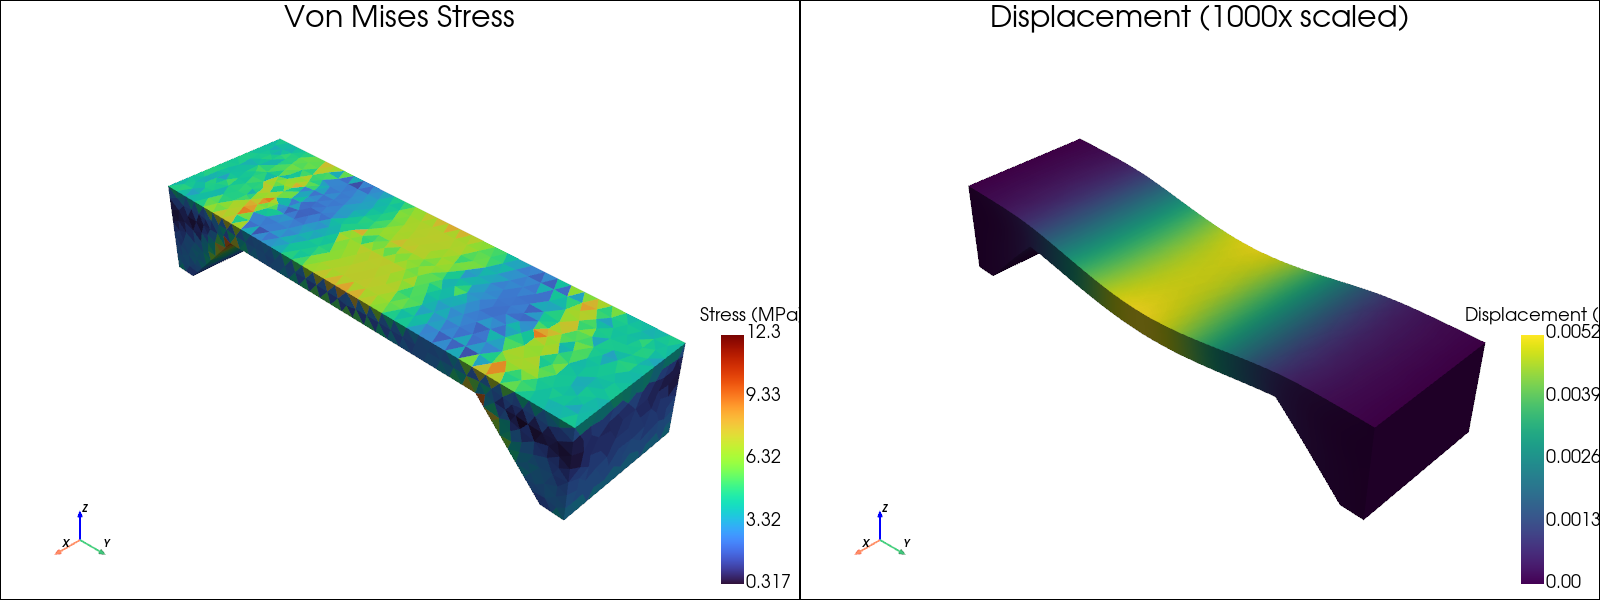

In [39]:
# Create an interactive plotter with multiple views
plotter = pv.Plotter(shape=(1, 2), window_size=[1600, 600])

# Left plot: Von Mises Stress
plotter.subplot(0, 0)
plotter.add_text("Von Mises Stress", font_size=12, position='upper_edge')
plotter.add_mesh(
    mesh,
    scalars='von_mises_stress',
    cmap='turbo',
    show_edges=False,
    scalar_bar_args={'title': 'Stress (MPa)', 'vertical': True}
)
plotter.camera_position = 'iso'
plotter.add_axes()

# Right plot: Displacement Magnitude (warped)
plotter.subplot(0, 1)
plotter.add_text("Displacement (1000x scaled)", font_size=12, position='upper_edge')
warped = mesh.warp_by_vector('displacement', factor=1000.0)  # Scale for visibility
plotter.add_mesh(
    warped,
    scalars='displacement_magnitude',
    cmap='viridis',
    show_edges=False,
    scalar_bar_args={'title': 'Displacement (mm)', 'vertical': True}
)
plotter.camera_position = 'iso'
plotter.add_axes()

# Show (interactive in some environments, static in notebooks)
plotter.show(jupyter_backend='static')  # Use 'static' for notebooks, remove for interactive

In [58]:
# Alternative: Save an interactive HTML file
plotter = pv.Plotter(notebook=False)
plotter.add_mesh(
    mesh,
    scalars='von_mises_stress',
    cmap='turbo',
    show_edges=True,
    edge_color='black',
    line_width=0.5,
    scalar_bar_args={'title': 'Von Mises Stress (MPa)'}
)
plotter.camera_position = 'iso'
plotter.add_axes()

# Save as interactive HTML (can open in browser)
plotter.export_html('stress_visualization.html')
print("✓ Saved interactive HTML: stress_visualization.html")
print("  Open in your web browser for interactive 3D view!")

plotter.close()

✓ Saved interactive HTML: stress_visualization.html
  Open in your web browser for interactive 3D view!


In [ ]:
# Create a screenshot with multiple stress components
plotter = pv.Plotter(shape=(2, 2), window_size=[1600, 1200], off_screen=True)

# Stress XX
plotter.subplot(0, 0)
plotter.add_text("σxx", font_size=14)
plotter.add_mesh(mesh, scalars='sigma_xx', cmap='RdBu_r', 
                scalar_bar_args={'title': 'σxx (MPa)'})
plotter.camera_position = 'iso'

# Stress YY
plotter.subplot(0, 1)
plotter.add_text("σyy", font_size=14)
plotter.add_mesh(mesh, scalars='sigma_yy', cmap='RdBu_r',
                scalar_bar_args={'title': 'σyy (MPa)'})
plotter.camera_position = 'iso'

# Stress ZZ
plotter.subplot(1, 0)
plotter.add_text("σzz", font_size=14)
plotter.add_mesh(mesh, scalars='sigma_zz', cmap='RdBu_r',
                scalar_bar_args={'title': 'σzz (MPa)'})
plotter.camera_position = 'iso'

# Von Mises
plotter.subplot(1, 1)
plotter.add_text("Von Mises", font_size=14)
plotter.add_mesh(mesh, scalars='von_mises_stress', cmap='turbo',
                scalar_bar_args={'title': 'Von Mises (MPa)'})
plotter.camera_position = 'iso'

# Save screenshot
plotter.screenshot('stress_components.png', transparent_background=False)
print("✓ Saved screenshot: stress_components.png")
plotter.close()

## 10. Comparison with Built-in torch-fem Meshes

Let's compare our imported mesh structure with torch-fem's built-in `cube_hexa` example to verify compatibility.

In [ ]:
# Create a simple cube mesh using torch-fem's built-in function
from torchfem.meshes import cube_hexa

# Generate a small cube mesh for comparison
cube_nodes, cube_elements = cube_hexa(Nx=3, Ny=3, Nz=3, Lx=10.0, Ly=10.0, Lz=10.0)

print("Built-in cube_hexa mesh:")
print(f"  Nodes shape: {cube_nodes.shape}")
print(f"  Elements shape: {cube_elements.shape}")
print(f"  Element type: Hexahedron (8 nodes per element)")

print("\nImported STEP mesh:")
print(f"  Nodes shape: {nodes.shape}")
print(f"  Elements shape: {elements.shape}")
print(f"  Element type: Tetrahedron (4 nodes per element)")

print("\n✓ Both meshes are compatible with torch-fem!")
print("  The key requirement is: nodes (n_nodes, n_dim), elements (n_elements, nodes_per_elem)")

## Summary

### Key Points:

1. **No subclassing needed!** The `import_geometry()` function returns torch tensors that are directly compatible with torch-fem's `Solid` class.

2. **Supported formats**: STEP (.step, .stp) and STL (.stl) files

3. **Element types**: 
   - `tet4`: 4-node linear tetrahedron (recommended for complex geometries)
   - `tet10`: 10-node quadratic tetrahedron
   - `hex8`: 8-node linear hexahedron
   - `hex20`: 20-node quadratic hexahedron

4. **Workflow**:
   ```python
   # Import geometry
   nodes, elements = import_geometry('file.step', mesh_size=1.0)
   
   # Create FEM model
   model = Solid(nodes, elements, material)
   
   # Apply BCs and solve
   model.solve()
   ```

5. **Utilities provided**:
   - `import_geometry()`: Main import function using gmsh
   - `find_nodes_in_box()`: Select nodes by bounding box
   - `export_to_vtk()`: Export results for ParaView
   - `extract_surface_nodes()`: Get surface nodes

### Next Steps:
- Adjust `mesh_size` for finer/coarser meshes
- Try different element types
- Import your own STEP/STL files
- Integrate with topology optimization workflows